In [57]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import os
import pickle

from helper_funcs import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# LOAD DATA
# First navigate to our directory
directory_path = os.path.join("Data", "spectra_and_noise_floors.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)
rng = np.random.default_rng()
f = rfftfreq(32768, 1/44100)[0:8192]
noise_floors = df['noise floor'].to_list()
spectra = df['spectrum'].to_list()
species_list = df['species'].to_list()
filepaths = df['filepath'].to_list()


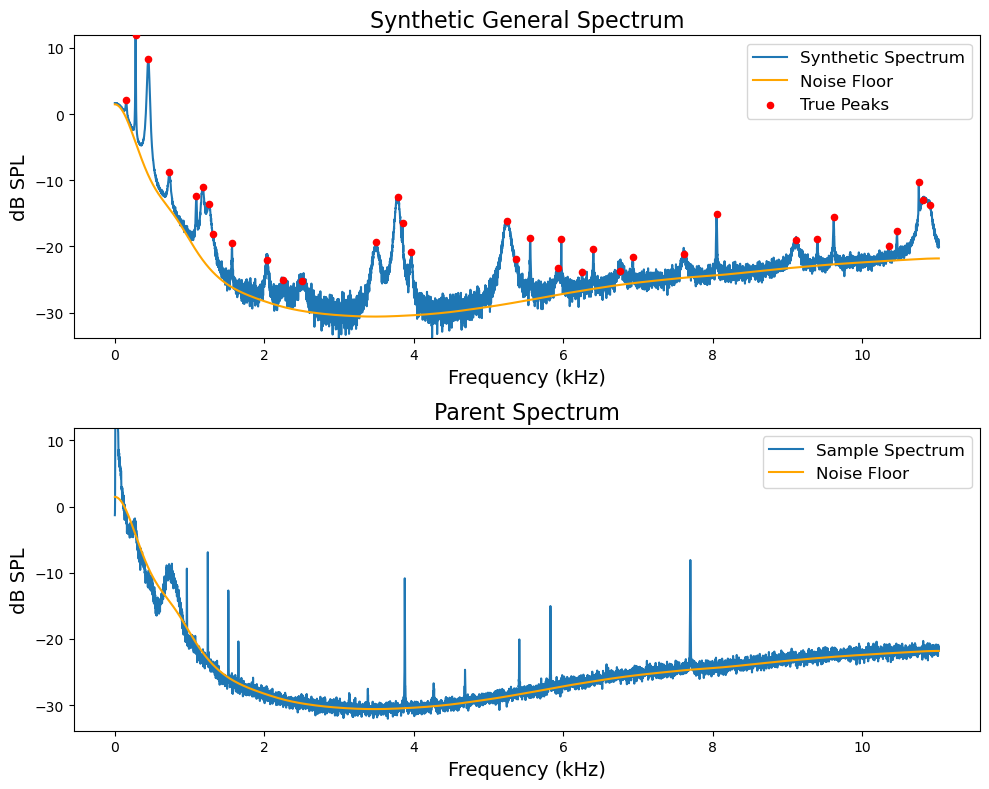

In [66]:
# Test synthetic spectra
i = rng.integers(0, len(spectra))
species = ['Human']
while species_list[i] not in species:
    # print(species_list[i])
    i = rng.integers(0, len(spectra))
    
# i = 1795
species = species_list[i]
# print(i)
species = 'General'

# d = synthesize_spectrum(spectra[i], noise_floors[i], f=f, species=species, filepath=filepaths[i], plot=True, noise_domain='linear')
d = synthesize_spectrum(spectra[i], noise_floors[i], f=f, species=species, filepath=filepaths[i], plot=True, save_name='general_synth_spectrum', noise_domain='linear')


8192
[2228 2229 2230]
3


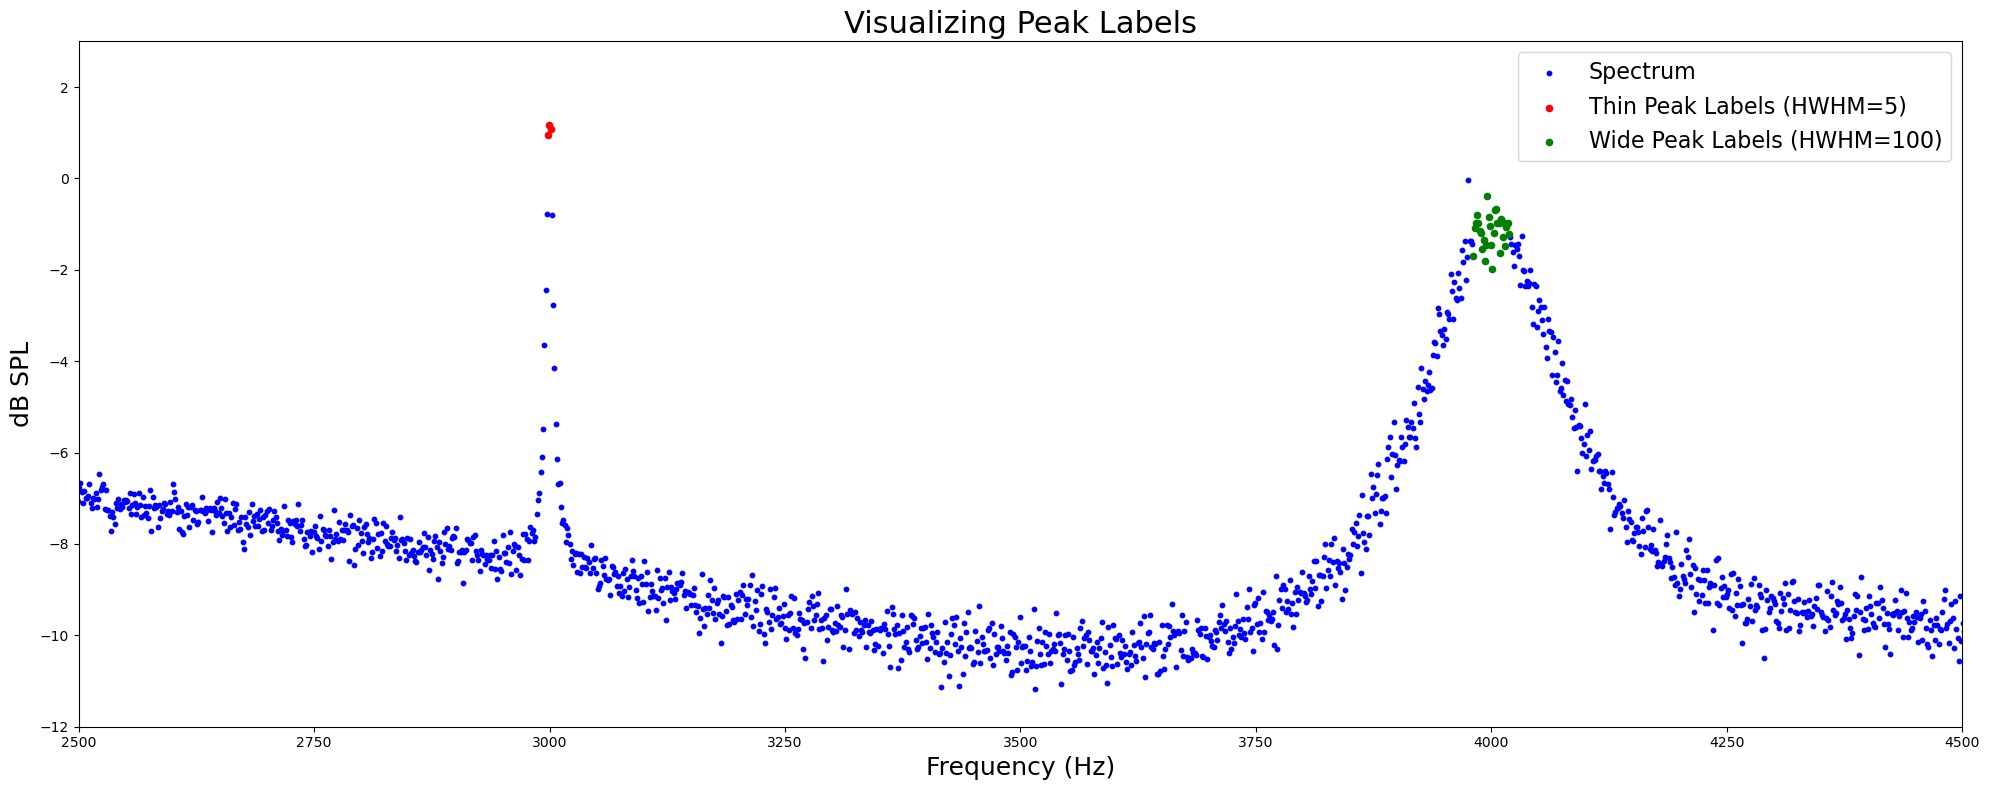

In [96]:
# Visualize peak bin labeling

# Set parameters
hwhm1 = 5
prominence1 = 10
label_hw1 = int((14 / 95) * hwhm1 + 5 / 19)
hwhm2 = 100
prominence2 = 10
label_hw2 = int((14 / 95) * hwhm2 + 5 / 19)
two_peak = True
f = rfftfreq(32768, 1/44100)[0:8192]

i = 100
# Get noise floor and parent spectrum
spectrum = noise_floors[i]
parent_spectrum = spectra[i]
# Add gaussian noise and plot spectrum
spectrum  = estimate_and_add_noise(spectrum, parent_spectrum, f=f, rng=rng, noise_domain='linear')
plt.figure(figsize=(20, 8))
# Add first peak
f1 = 3000
f1_i = np.argmin(np.abs(f - f1))
print(len(lorentzian(f, f[f1_i], hwhm1, prominence1)))
spectrum = spectrum + lorentzian(f, f[f1_i], hwhm1, prominence1)
# Make arrays that are f1_i +\- label_hw number of bins
f1_i = np.arange(f1_i - label_hw1, f1_i + label_hw1 + 1)

# Add second peak
if two_peak:
    f2 = f1 + 1000
    f2_i = np.argmin(np.abs(f - f2))
    spectrum = spectrum + lorentzian(f, f[f2_i], hwhm2, prominence2)
    f2_i = np.arange(f2_i - label_hw2, f2_i + label_hw2 + 1)

plt.scatter(f, spectrum, color='blue', label='Spectrum', s=10)
plt.scatter(f[f1_i], spectrum[f1_i], color='red', label=f'Thin Peak Labels (HWHM={hwhm1})', s=20)
if two_peak:
    plt.scatter(f[f2_i], spectrum[f2_i], color='green', label=f'Wide Peak Labels (HWHM={hwhm2})', s=20)
    
print(f1_i)
print(len(f1_i))

plt.title(f"Visualizing Peak Labels", fontsize=22)
plt.xlim(f1 - 500, f2 + 500)
plt.ylim(-12, 3)
plt.xlabel("Frequency (Hz)", fontsize=18)
plt.ylabel("dB SPL", fontsize=18)
plt.legend(fontsize=16)
# Adjust margins
plt.tight_layout()
plt.savefig(f"peak_labels.png")
plt.show()


In [ ]:
# Generate Synthetic Spectra for Chris Inspection
for species in ['Human', 'Lizard']:
    for j in range(50):
        print(f"Generating {species} {j}")
        i = rng.integers(0, len(spectra))
        while species_list[i] != species:
            i = rng.integers(0, len(spectra))
        save_name = f"{species} {j}.png"
        d = synthesize_spectrum(spectra[i], noise_floors[i], f=f, species=species, filepath=filepaths[i], plot=True, save_name=save_name, noise_domain='linear')
        
# General
species = 'General'
for j in range(50):
    print(f"Generating {species} {j}")
    i = rng.integers(0, len(spectra))
    save_name = f"{species} {j}.png"
    d = synthesize_spectrum(spectra[i], noise_floors[i], f=f, species=species, filepath=filepaths[i], plot=True, save_name=save_name, noise_domain='linear')

# # dB Scale Noise
# for species in ['Human', 'Lizard']:
#     for j in range(20):
#         print(f"Generating dB {species} {j}")
#         i = rng.integers(0, len(spectra))
#         while species_list[i] != species:
#             i = rng.integers(0, len(spectra))
#         save_name = f"dB Scale Noise {species} {j}.png"
#         d = synthesize_spectrum(spectra[i], f=f, species=species, filepath=filepaths[i], plot=True, save_name=save_name, noise_domain='log')
# species = 'General'
# for j in range(20):
#     print(f"Generating dB {species} {j}")
#     i = rng.integers(0, len(spectra))
#     save_name = f"dB Scale Noise {species} {j}.png"
#     d = synthesize_spectrum(spectra[i], f=f, species=species, filepath=filepaths[i], plot=True, save_name=save_name, noise_domain='log')

In [ ]:
# Parameters for the chi-square distribution
chi_dof = 23 # Degrees of freedom (k)
chi_og_pivot = 10
chi_new_pivot = 1200

# Generate samples from a chi-square distribution
num_samples = 10000  # Number of samples to generate
chi_square_samples_unscaled = np.random.chisquare(df=chi_dof, size=num_samples)  # Unscaled
chi_square_samples_scaled = chi_square_samples_unscaled * chi_new_pivot / chi_og_pivot  # Scaled

# Create subplots for unscaled and scaled distributions
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the unscaled chi-square distribution
axs[0].hist(chi_square_samples_unscaled, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
axs[0].set_title(f'Unscaled Chi-Square Distribution (k={chi_dof})')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Density')
axs[0].grid(True)

# Plot the scaled chi-square distribution
axs[1].hist(chi_square_samples_scaled, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
axs[1].set_title(f'Scaled Chi-Square Distribution (k={chi_dof})')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')
axs[1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [ ]:
# VISUALIZE LORENTZIAN
f = rfftfreq(32768, 1/44100)
f0 = f[5000]
snr = 20
hwhm1 = 1

plt.plot(f, lorentzian(f, f0, hwhm1, snr))
plt.plot(f, np.ones(len(f)) * 10)
plt.xlim(f0-2, f0+2)
plt.show()

In [ ]:
# VISUALIZE NOISE FLOOR
# Get frequency axis
f = rfftfreq(32768, 1/44100)[0:8192]

# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)

df = df[df['filepath'].str.contains("UWO Data")]
df = df[df['filepath'].str.contains("waveform")]
df = df.sample(frac=1).reset_index(drop=True)
spectrums = df['spectrum'].to_list()
filepaths = df['filepath'].to_list()
species = df['species'].to_list()

In [ ]:
frac_broad= 0.3
smoothing_sigma = 150
fit_close_cutoff = 300

i = 0

for spectrum, filepath in zip(spectrums, filepaths):
    i+=1
    if i > 10:
        break
    
    
    noise_floor = get_noise_floor(f, spectrum)
    plt.plot(f, spectrum, label='Original Spectrum')
    # plt.plot(f, min_spectrum, 'black', label='min_spectrum')
    # plt.plot(f, fit_broad,'g--',label='Broad LOWESS Fit')
    # plt.plot(f, fit_close,'r--',label='Close LOWESS Fit')
    plt.plot(f, noise_floor,'black',label='Noise Floor')
    plt.legend()
    plt.title(filepath)
    plt.savefig(filepath + ".png")
    plt.show()
    

In [ ]:
# Finding noise distribution


# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)
# Get frequncy axis
f = rfftfreq(32768, 1/44100)[0:8192]


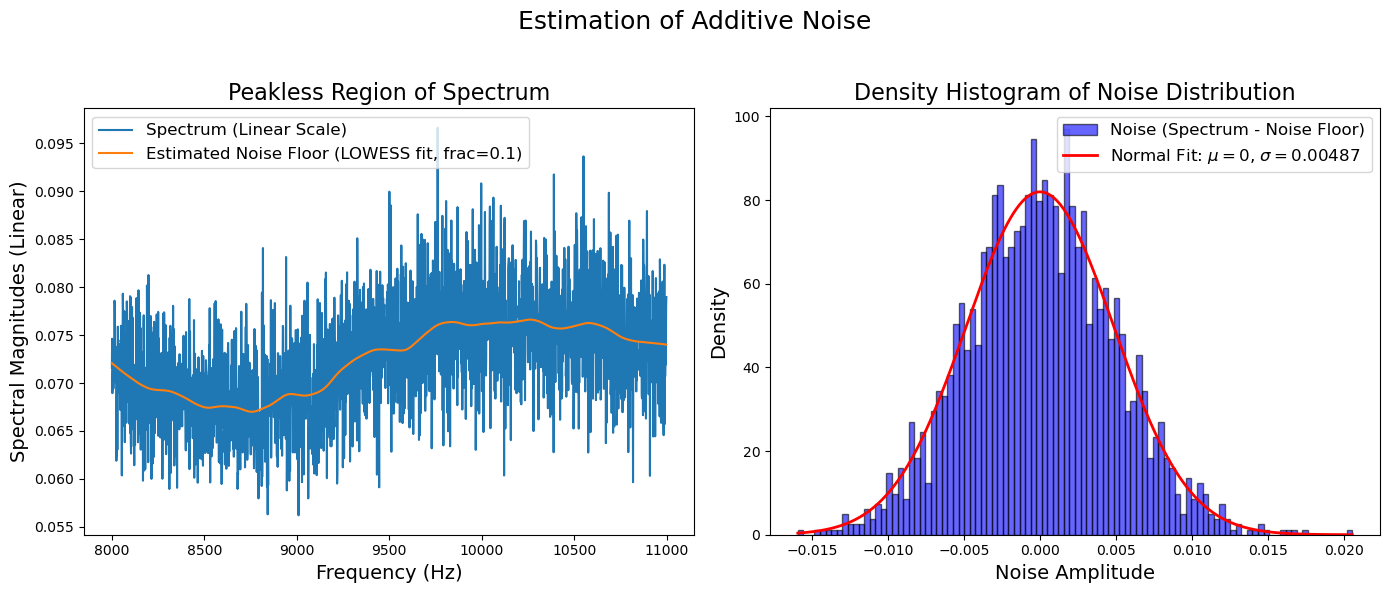

In [70]:
# Plots for normally distributed additive noise
f = rfftfreq(32768, 1/44100)[0:8192]
index = 2000
spectrum = df.iloc[index]['spectrum']
filepath = df.iloc[index]['filepath']
# Cut this off to 8000 and 11000
f_min = np.argmin(np.abs(f - 8000))
f_max = np.argmin(np.abs(f - 11000))
f = f[f_min:f_max]
spectrum = spectrum[f_min:f_max]

linear_spectrum = 10**(spectrum/20)
lowess = sm.nonparametric.lowess
frac = 0.1
linear_lowess_fit = lowess(linear_spectrum, f, frac=frac, return_sorted=False)
linear_noise = linear_spectrum - linear_lowess_fit

# Fit a normal distribution to the data using MLE
std = np.sqrt(np.mean((linear_noise)**2))
mean = 0

# Generate normal distribution curve
x = np.linspace(min(linear_noise), max(linear_noise), 1000)
pdf = norm.pdf(x, mean, std)

# PLOT
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create 1 row, 2 columns of subplots

# Plot One: Noise floor and spectrum
axes[0].plot(f, linear_spectrum, label="Spectrum (Linear Scale)")
axes[0].plot(f, linear_lowess_fit, label=f"Estimated Noise Floor (LOWESS fit, frac={frac})")
axes[0].set_xlabel("Frequency (Hz)", fontsize=14)
axes[0].set_ylabel("Spectral Magnitudes (Linear)", fontsize=14)
axes[0].set_title("Peakless Region of Spectrum", fontsize=16)
axes[0].legend(fontsize=12)

# Plot Two: Histogram of linear noise
axes[1].hist(linear_noise, bins=100, density=True, color='blue', alpha=0.6, label='Noise (Spectrum - Noise Floor)', edgecolor='black')
axes[1].plot(x, pdf, color='red', linewidth=2, label=f'Normal Fit: $\mu=0$, $\sigma={np.round(std, 5)}$')
axes[1].set_title("Density Histogram of Noise Distribution", fontsize=16)
axes[1].set_xlabel("Noise Amplitude", fontsize=14)
axes[1].set_ylabel("Density", fontsize=14)
axes[1].legend(fontsize=12)

# Add a shared title for the entire figure
fig.suptitle("Estimation of Additive Noise", fontsize=18)

# Adjust layout to avoid overlapping elements
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('sigma_estimation.png')

# Show the plots
plt.show()



In [ ]:
db_lowess_fit = lowess(spectrum, f, frac=frac, return_sorted=False)
linear_noise = linear_spectrum - linear_lowess_fit
db_noise = spectrum - db_lowess_fit
# Histogram for linear noise

# Fit a normal distribution to the data using MLE
mean, std = norm.fit(linear_noise)
print(mean)

# Generate points for the normal distribution curve
x = np.linspace(min(linear_noise), max(linear_noise), 1000)
pdf = norm.pdf(x, mean, std)

# Plot the histogram
plt.hist(linear_noise, bins=100, density=True, color='blue', alpha=0.6, label='Data', edgecolor='black')

# Plot the normal distribution curve
plt.plot(x, pdf, color='red', linewidth=2, label='Normal Fit')

plt.title("Linear Noise")

plt.show()

# # Histogram for dB noise

# # Fit a normal distribution to the data
# mean, std = norm.fit(db_noise)
# print(mean)

# # Generate points for the normal distribution curve
# x = np.linspace(min(db_noise), max(db_noise), 1000)
# pdf = norm.pdf(x, mean, std)

# # Plot the histogram
# plt.hist(db_noise, bins=100, density=True, color='blue', alpha=0.6, label='Data', edgecolor='black')

# # Plot the normal distribution curve
# plt.plot(x, pdf, color='red', linewidth=2, label='Normal Fit')

# plt.title("dB Noise")

# plt.show()

In [ ]:
# Get sigmas
sigmas = np.empty(len(spectra))
for i, spectrum in enumerate(spectra):
    sigmas[i] = estimate_noise_sigma(spectrum, f=f, noise_domain='log')
    print(f"Processing {i}/{len(spectra)}")

sigmas_df = pd.DataFrame(sigmas, columns=['Sigma'])
sigmas_df.to_parquet('sigmas.parquet')    
    

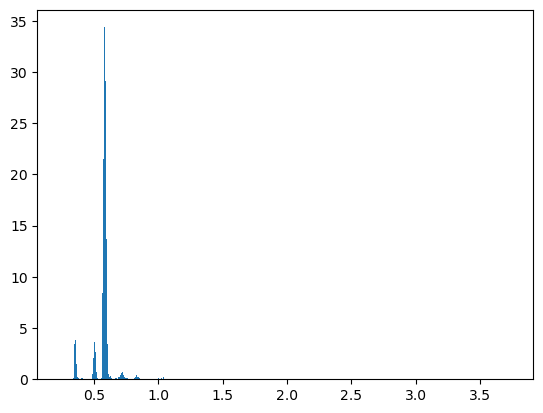

In [75]:
sigmas = pd.read_parquet(os.path.join('Data', 'sigmas.parquet'))['Sigma'].to_list()
plt.hist(sigmas, bins=500, density=True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

# Parameters
fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 1, fs, endpoint=False)  # Time vector for 1 second
f = 100  # Sine wave frequency (Hz)
amplitude = 1  # Amplitude of the sine wave

# Generate sine wave
sine_wave = amplitude * np.sin(2 * np.pi * f * t)

# Add random uniform noise
NA = 5
noise = np.random.normal(0, NA, size=t.shape)
sine_wave_with_noise = sine_wave + noise

# Perform rFFT (normalized by N/2)
N = len(t)
frequencies = rfftfreq(N, 1/fs)
spectrum_clean = np.abs(rfft(sine_wave)) / (N/2)
spectrum_noisy = np.abs(rfft(sine_wave_with_noise)) / (N/2)
noise_spectrum = np.abs(rfft(noise)) / (N/2)    

# Plotting
plt.figure(figsize=(12, 6))

# Spectrum without noise
plt.subplot(2, 1, 1)
plt.plot(frequencies, spectrum_clean, label='Clean Signal')
plt.title('Spectrum of Sine Wave (No Noise)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.ylim(0, 1.5)
plt.grid()
plt.legend()

# Spectrum with noise
plt.subplot(2, 1, 2)
plt.plot(frequencies, spectrum_noisy, label='Noisy Signal', color='orange')
plt.plot(frequencies, noise_spectrum, label='Noise', color='blue')
plt.title('Spectrum of Sine Wave (With Noise)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.ylim(0, 1.5)
plt.grid()
plt.legend()


plt.tight_layout()
plt.show()
